In [8]:
!pip install -r requirements.txt

  Using cached matplotlib-3.8.3-cp310-cp310-win_amd64.whl.metadata (5.9 kB)
  Using cached contourpy-1.2.0-cp310-cp310-win_amd64.whl.metadata (5.8 kB)
  Using cached cycler-0.12.1-py3-none-any.whl.metadata (3.8 kB)
     ---------------------------------------- 0.0/162.6 kB ? eta -:--:--
     ------------------------------------- 162.6/162.6 kB 10.2 MB/s eta 0:00:00
  Using cached kiwisolver-1.4.5-cp310-cp310-win_amd64.whl.metadata (6.5 kB)
  Using cached pillow-10.2.0-cp310-cp310-win_amd64.whl.metadata (9.9 kB)
  Using cached pyparsing-3.1.2-py3-none-any.whl.metadata (5.1 kB)
Using cached matplotlib-3.8.3-cp310-cp310-win_amd64.whl (7.6 MB)
Using cached contourpy-1.2.0-cp310-cp310-win_amd64.whl (186 kB)
Using cached cycler-0.12.1-py3-none-any.whl (8.3 kB)
   ---------------------------------------- 0.0/2.2 MB ? eta -:--:--
   ---------------------------------------  2.2/2.2 MB 46.2 MB/s eta 0:00:01
   ---------------------------------------- 2.2/2.2 MB 46.2 MB/s eta 0:00:00
Using cached

Notebook for analysing the data corpus

In [246]:
corp_path = './data'
images_path = './images'

import networkx as nx
import os
import re
import pandas as pd
import json
from matplotlib import pyplot as plt

definitions_path = corp_path + './definitions.json'
definitions = json.load(open(definitions_path, encoding='utf-8'))

discussion_path = corp_path + './discussion_data.xlsx'
discussion_data = pd.read_excel(discussion_path).copy()

# Some preprocessing
# Change all 'Imaginative' values to 'Imaginative entry'
discussion_data = discussion_data.replace('Imaginative entry', 'Imaginative')

0      Imaginative
1        Procedure
2        Procedure
3          Seminar
4          Seminar
          ...     
246        Seminar
247        Seminar
248        Seminar
276        Seminar
421        Seminar
Name: R1 Discussion type, Length: 416, dtype: object


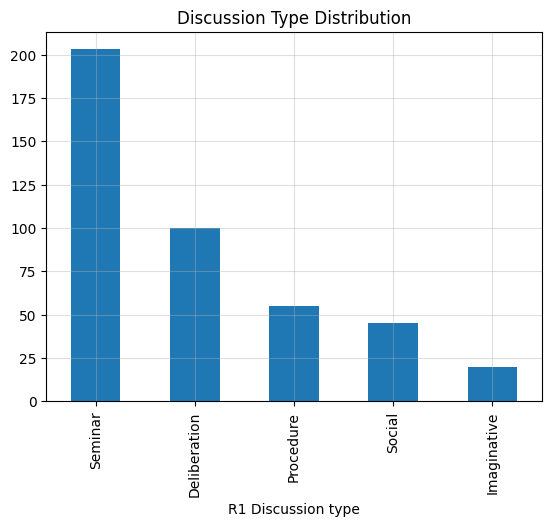

In [267]:
# Extract all entries where 'R1 Discussion type' is not none, if it is none, take the 'R2 Discussion type'
discussion_types = discussion_data[discussion_data['R1 Discussion type'].notna()]

# Add the rows where 'R1 Discussion type' is none and 'R2 Discussion type' is not none and set the 'R2 Discussion type' as the 'R1 Discussion type'
discussion_types = pd.concat([discussion_types, discussion_data[discussion_data['R1 Discussion type'].isna() & discussion_data['R2 Discussion Type'].notna()]])
discussion_types['R1 Discussion type'] = discussion_types['R1 Discussion type'].fillna(discussion_types['R2 Discussion Type'])

# Get all rows with multiple values in 'R2 Discussion Type' column
multi_discussion_rows = discussion_types[discussion_types['R1 Discussion type'].str.contains(', ', na=False)]

# Remove them from the original dataframe
discussion_data_no_multi = discussion_types[~discussion_types['R1 Discussion type'].str.contains(', ', na=False)]

# Get count of each discussion type
r2_discussion_types = discussion_data_no_multi['R1 Discussion type'].value_counts()

# Add the multi-discussion rows to the count
for row in multi_discussion_rows.iterrows():
    for d_type in row[1]['R1 Discussion type'].split(', '):
        d_type = d_type.strip()
        if d_type in r2_discussion_types:
            r2_discussion_types[d_type] += 1


r2_discussion_types.plot(kind='bar', title='Discussion Type Distribution')
# Show grid
plt.grid(alpha=0.4)

# Remove the bottom title
plt.suptitle('')

# Save the plot
plt.savefig(images_path + '/discussion_type_distribution.pdf', bbox_inches='tight')


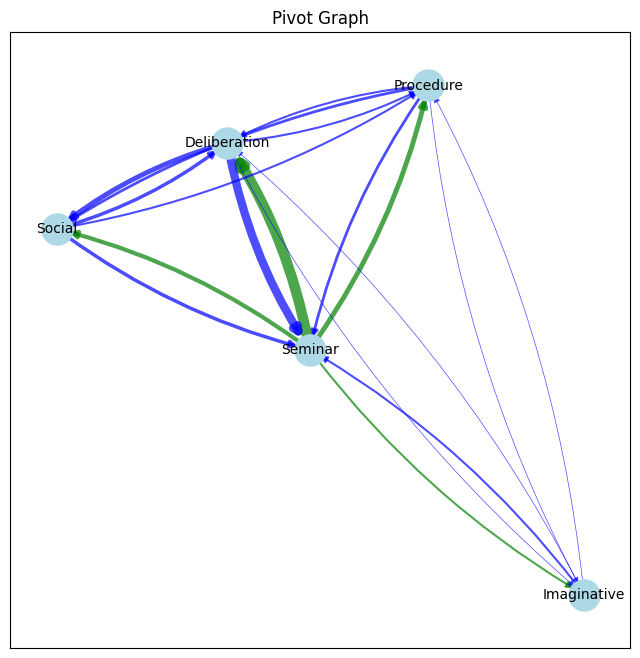

In [242]:
# Extract all entries where 'R1 Pivot' is not none, if it is none, take the 'R2 Pivot'
pivot_entries = list(discussion_data_no_multi[discussion_data_no_multi['R1 Pivot'].notna()]['R1 Pivot'])

# Add the rows where 'R1 Pivot' is none and 'R2 Pivot' is not none
pivot_entries.extend(list(discussion_data_no_multi[(discussion_data_no_multi['R1 Pivot'].isna()) & (discussion_data_no_multi['R2 Pivot'].notna())]['R2 Pivot']))

G = nx.MultiDiGraph(directed=True)

# Add nodes
G.add_nodes_from(r2_discussion_types.index)
for pivot in pivot_entries:
    from_node, to_node = pivot.split(' to ', maxsplit=1)
    # Capitalize first letter of each word
    from_node = from_node[0].upper() + from_node[1:].strip()
    to_node = to_node[0].upper() + to_node[1:].strip()

    if '/' in from_node:
        from_node = from_node.split('/')[0]
    if '/' in to_node:
        to_node = to_node.split('/')[0]

    to_to_node = None

    if from_node == 'Imaginative entry':
        from_node = 'Imaginative'
    
    if to_node == 'Imaginative entry':
        to_node = 'Imaginative'

    if 'to' in to_node:
        to_node, to_to_node = to_node.split(' to ', maxsplit=1)
        to_to_node = to_to_node[0].upper() + to_to_node[1:]
    
    # Add edge
    if G.has_edge(from_node, to_node):
        G[from_node][to_node][0]['weight'] += 1
    else:
        G.add_edge(from_node, to_node, weight=1)

    if to_to_node:
        if G.has_edge(to_node, to_to_node):
            G[to_node][to_to_node][0]['weight'] += 1
        else:
            G.add_edge(to_node, to_to_node, weight=1)

# Init plot
plt.figure(figsize=(8, 8))
plt.tight_layout()
plt.title('Pivot Graph')

# Draw the graph nodes
pos = nx.spring_layout(G)
nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=500)

# Iterate edges
for (u, v, d) in G.edges(data=True):
    # Draw every edge separately with its weight
    nx.draw_networkx_edges(G, pos, edgelist=[(u, v)], width=0.5*d['weight'], alpha=[0.7*d['weight']/max(G[u][v][0]['weight'], 1)], edge_color=['green' if u=='Seminar' else 'blue'],connectionstyle="arc3,rad=0.1")

# Draw the labels
_=nx.draw_networkx_labels(G, pos, font_size=10, font_family='sans-serif')

# Save fig
plt.savefig(images_path + '/pivot_graph.pdf', bbox_inches='tight')
    